# CH02 추세분석

## 1. 패키지 불러오기

In [1]:
library(lmtest)
library(ggplot2)
library(lubridate)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [26]:
setwd('/root/TS2024/data')
options(repr.plot.width = 10, repr.plot.height = 6)

## 2. Data

`-` 한국 인구수 시계열 데이터(1960~)

In [65]:
z = as.numeric(read.csv("population.csv")[-c(1, 2),2])[1:36]
head(z)

[1] 25012374 25765673 26513030 27261747 27984155 28704674

In [66]:
pop = round(z/10000) ## 너무 크므로 스케일링
head(pop)

[1] 2501 2577 2651 2726 2798 2870

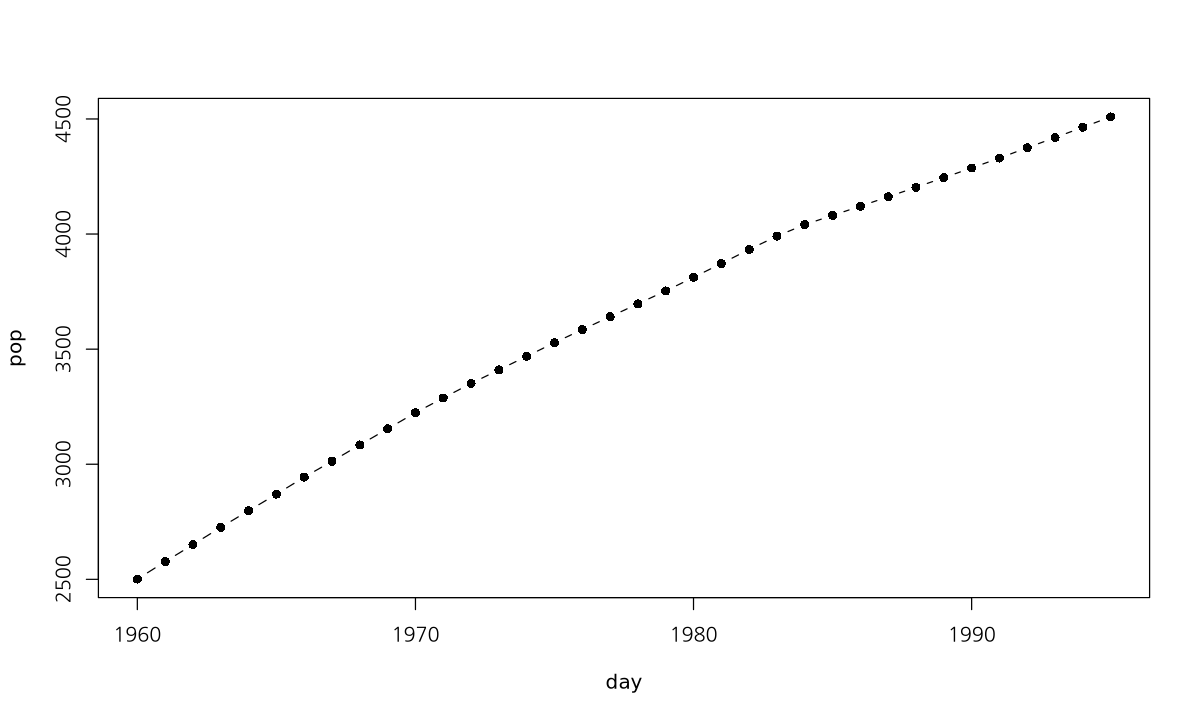

In [67]:
day = seq(ymd("1960-01-01"), by = 'year', length.out=length(z))
plot(day, pop, type = 'b', pch = 16)

`-` `ggplot`을 이용한 시각화

In [68]:
tmp_data = data.frame(
    day = seq(ymd("1960-01-01"), by = 'year', length.out=length(z)),
    pop = round(z/10000),
    t = 1:length(z),
    t2 = (1:length(z))^2
    )
head(tmp_data)

,day,pop,t,t2
,<date>,<dbl>,<int>,<dbl>
1,1960-01-01,2501,1,1
2,1961-01-01,2577,2,4
3,1962-01-01,2651,3,9
4,1963-01-01,2726,4,16
5,1964-01-01,2798,5,25
6,1965-01-01,2870,6,36


`-` `scale_x_date(date_labels)`로 레이블 표기 방식을 바꿀 수 있다.

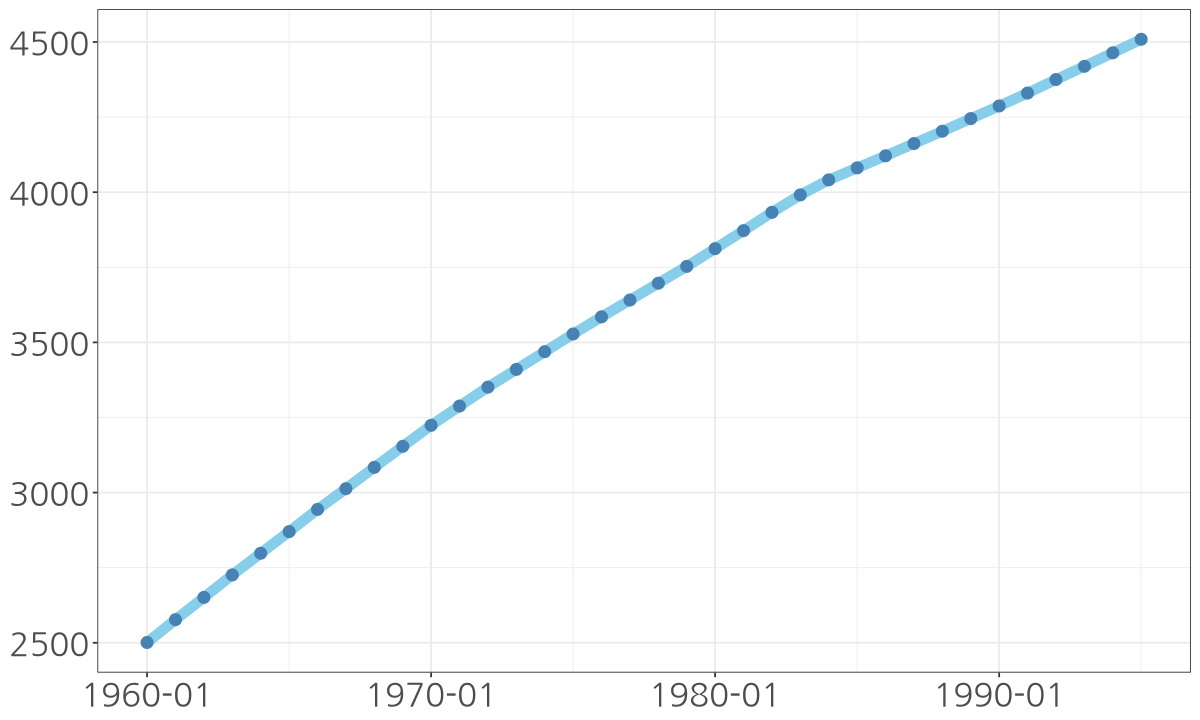

In [69]:
ggplot(tmp_data, aes(day, pop)) +
    geom_line(col = 'skyblue', lwd = 3) +
    geom_point(col = 'steelblue', cex = 3) +
    theme_bw() +
    scale_x_date(date_labels = "%Y-%m") + ## 레이블의 표기 형식에 원하는 옵션을 줄 수 있음
    theme(axis.title = element_blank(),
          axis.text = element_text(size=20)) ## axis label을 제거하고, 범례의 사이즈를 키움

## 3. 추세모형

### **A. 1차 선형 추세 모형**

모형 : $Z_t = \beta_0 + \beta_1 t + \epsilon_t,~ \epsilon_t \overset{i.i.d.}{\sim} N(0, \sigma^2), ~ t = 1, \cdots, n$

In [70]:
m1 = lm(pop~t, data = tmp_data)
summary(m1)


Call:
lm(formula = pop ~ t, data = tmp_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-115.40  -48.30   16.87   54.37   63.29 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2559.3889    20.0385  127.72   <2e-16 ***
t             57.0135     0.9444   60.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 58.87 on 34 degrees of freedom
Multiple R-squared:  0.9908,	Adjusted R-squared:  0.9905 
F-statistic:  3644 on 1 and 34 DF,  p-value: < 2.2e-16


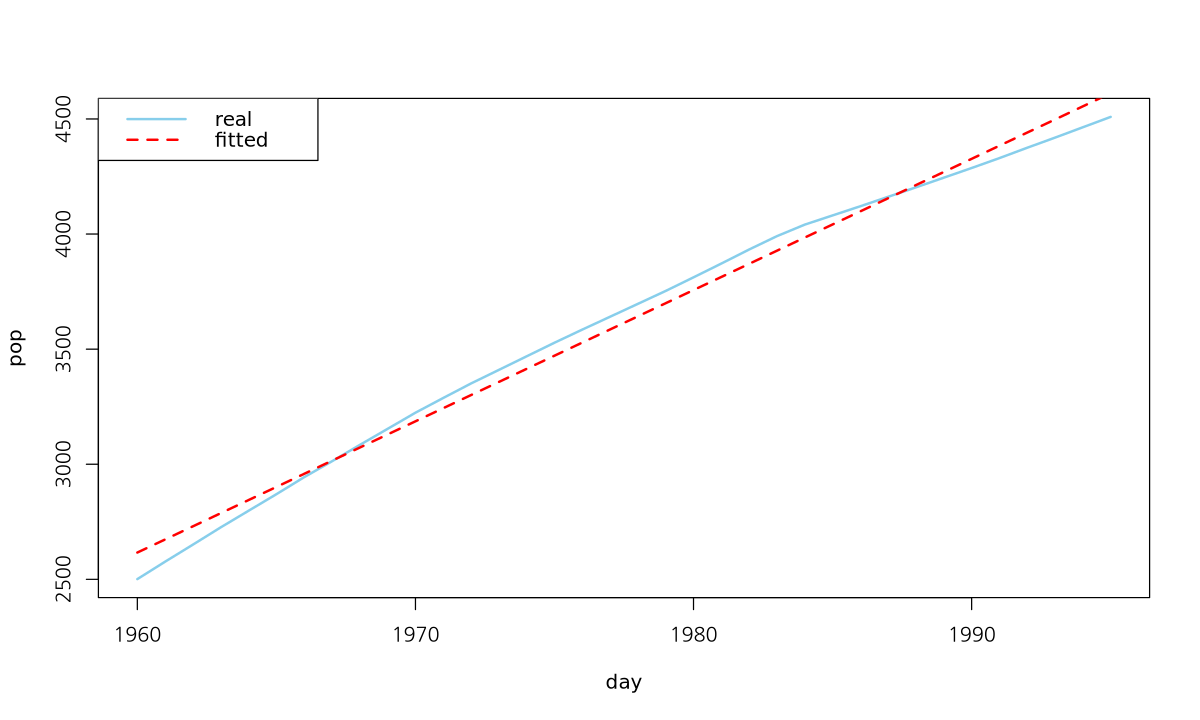

In [71]:
plot(pop~day, tmp_data, type = 'l', col = 'skyblue', lwd = 2) ## Real
lines(day, fitted(m1), col = 'red', lty = 2, lwd = 2) ## Fitted
legend('topleft', c('real', 'fitted'), col = c('skyblue', 'red'), lty = 1:2, lwd = 2)

`-` 잔차분석

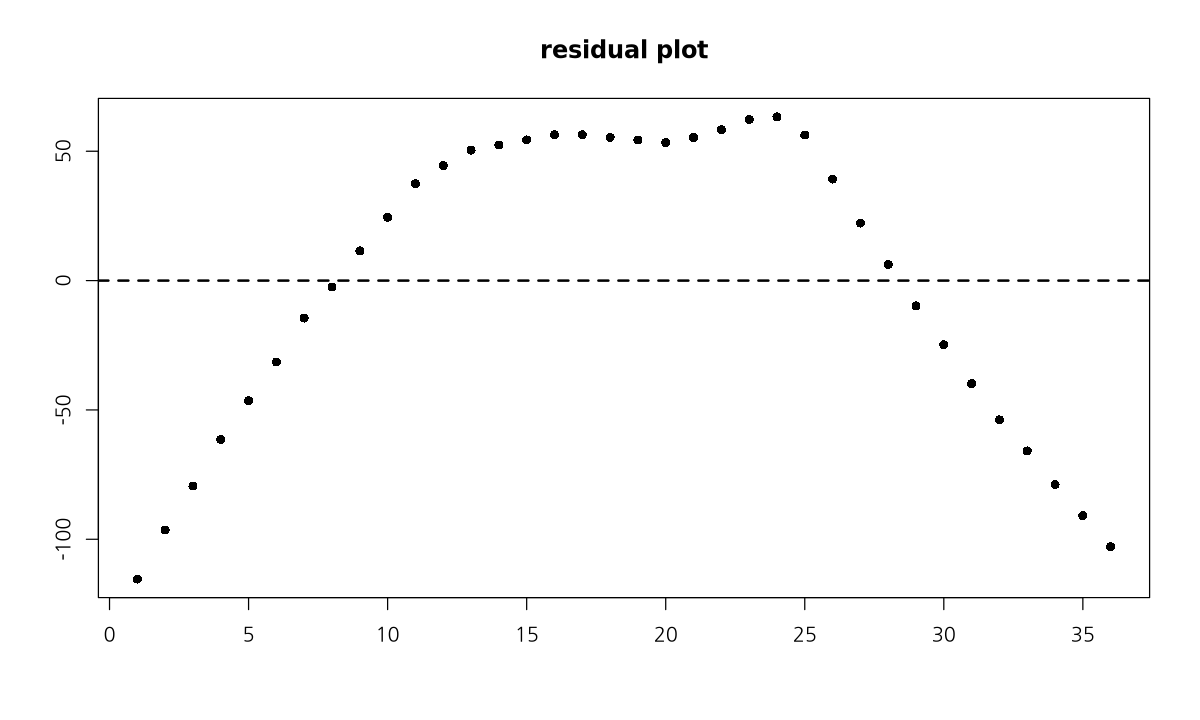

In [72]:
plot(tmp_data$t, resid(m1), pch = 16, main = 'residual plot', xlab = "", ylab = "")
abline(h = 0, lty = 2, lwd = 2)

`-` 독립성 검정 : DW test

In [73]:
dwtest(m1)


	Durbin-Watson test

data:  m1
DW = 0.041645, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0


In [74]:
dwtest(m1, alternative = 'two.sided')


	Durbin-Watson test

data:  m1
DW = 0.041645, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is not 0


In [75]:
dwtest(m1, alternative = 'less')


	Durbin-Watson test

data:  m1
DW = 0.041645, p-value = 1
alternative hypothesis: true autocorrelation is less than 0


> 애초에 잔차 그림 자체가 선형성 위배이기 때문에 2차 형태를 고려해야 한다.

`-` 정규성 검정 : Shapiro-wilk test

가설 : $H_0 :$ 정규분포를 따른다, $H_1 :$ 정규분포를 따르지 않는다.

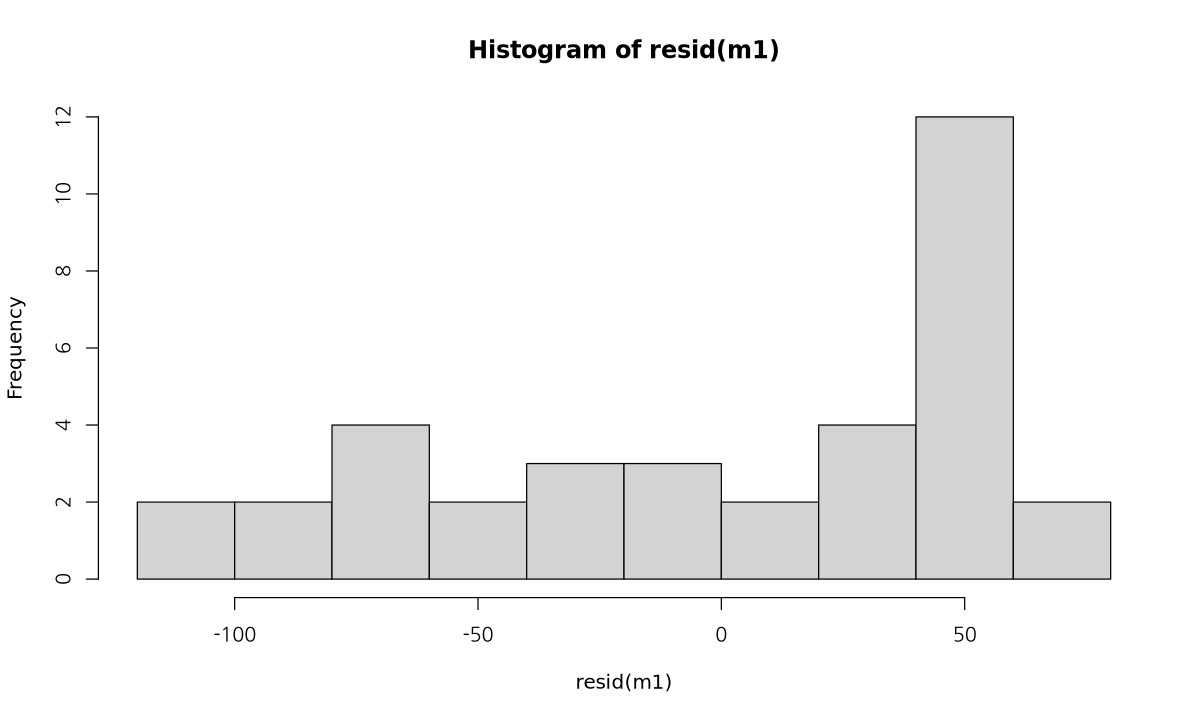

In [76]:
hist(resid(m1))

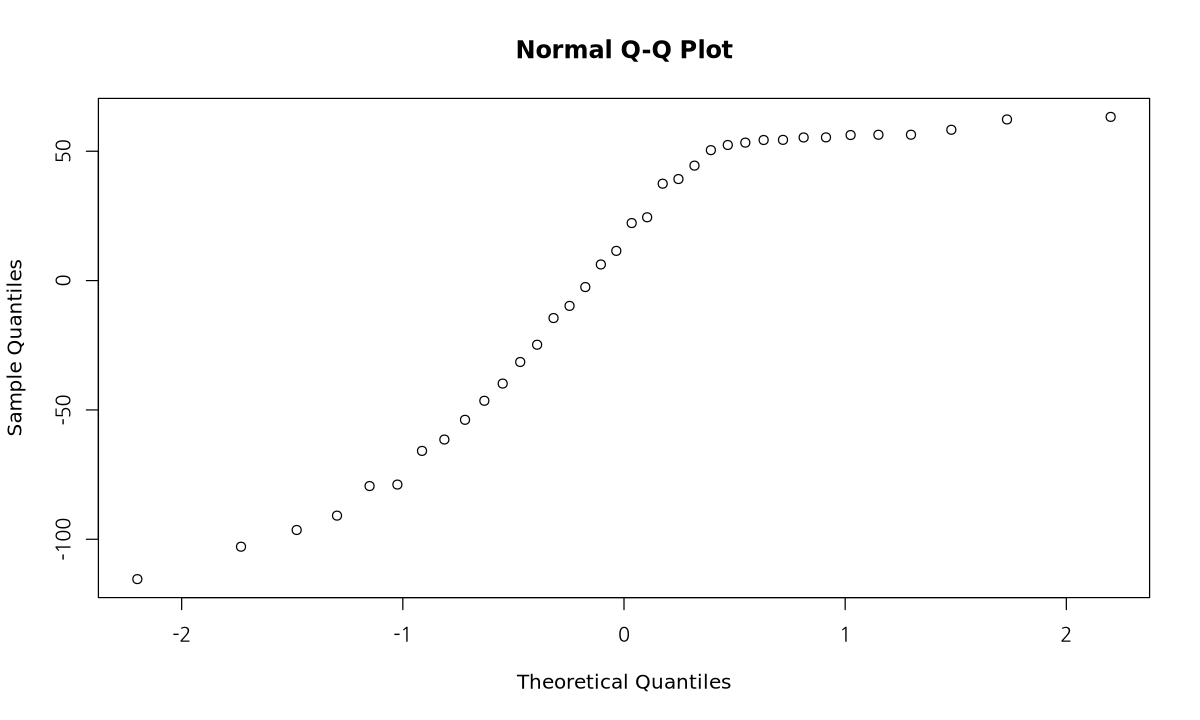

In [77]:
qqnorm(resid(m1))

In [78]:
shapiro.test(resid(m1))


	Shapiro-Wilk normality test

data:  resid(m1)
W = 0.87284, p-value = 0.000669


> p-value가 매우 낮기 때문에 정규분포를 따르지 않는다.

`-` 등분산성 검정(Breusch-Pagan test)

가설 : $H_0 : $ 등분산 vs. $H_1 : $ 이분산

In [79]:
bptest(m1)


	studentized Breusch-Pagan test

data:  m1
BP = 0.0059664, df = 1, p-value = 0.9384


> p-value가 매우 커서 등분산성 가정 위배하지 않음.

### B. 2차 선형 추세모형

모형 : $Z_t = \beta_0 + \beta_1 t \beta_2 t^2 + \epsilon_t, ~ t = 1, \cdots, n$

In [80]:
m2 = lm(pop~t+I(t^2), data = tmp_data) ## 또는 제곱항을 직접 만들어서 적용
summary(m2)


Call:
lm(formula = pop ~ t + I(t^2), data = tmp_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.365  -4.779  -1.049   3.798  17.631 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2421.49090    4.05820  596.69   <2e-16 ***
t             78.78688    0.50576  155.78   <2e-16 ***
I(t^2)        -0.58847    0.01326  -44.38   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.67 on 33 degrees of freedom
Multiple R-squared:  0.9998,	Adjusted R-squared:  0.9998 
F-statistic: 1.083e+05 on 2 and 33 DF,  p-value: < 2.2e-16


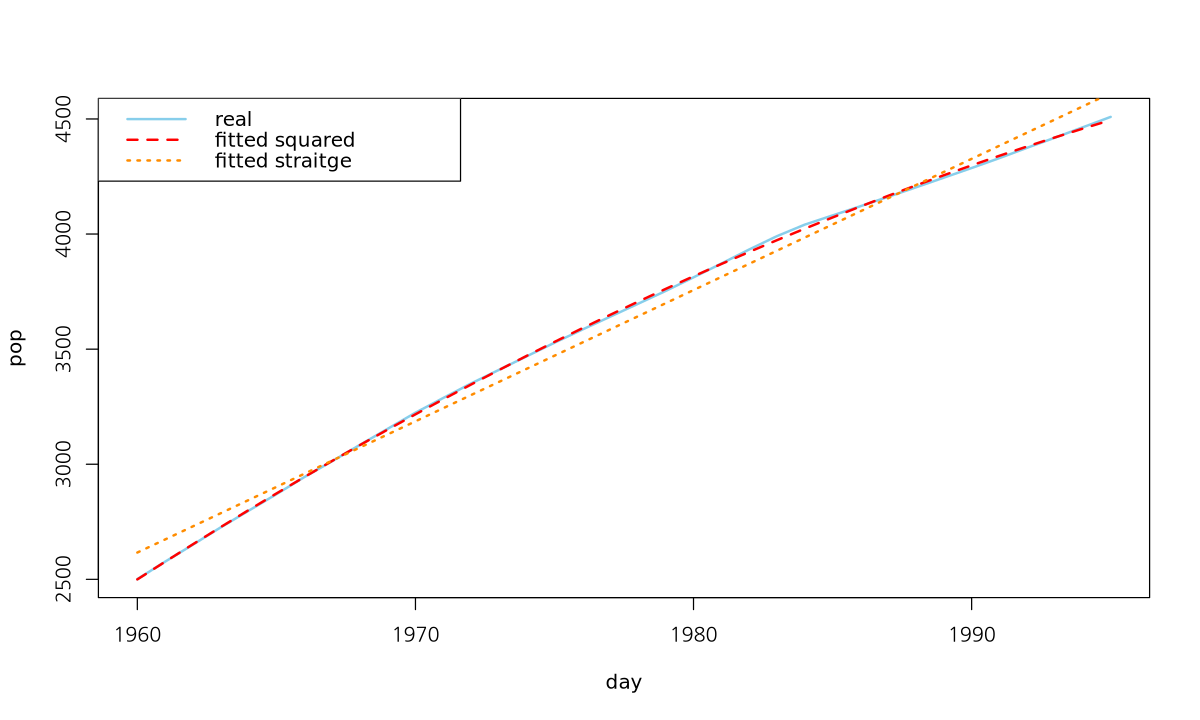

In [86]:
plot(pop~day, tmp_data, type = 'l', col = 'skyblue', lwd = 2) ## Real
lines(day, fitted(m2), col = 'red', lty = 2, lwd = 2) ## Fitted
lines(day, fitted(m1), col = 'darkorange', lty = 3, lwd = 2) ## Fitted
legend('topleft', c('real', 'fitted squared', 'fitted straitge'),
       col = c('skyblue', 'red', 'darkorange'), lty = 1:3, lwd = 2)

`-` 잔차 분석

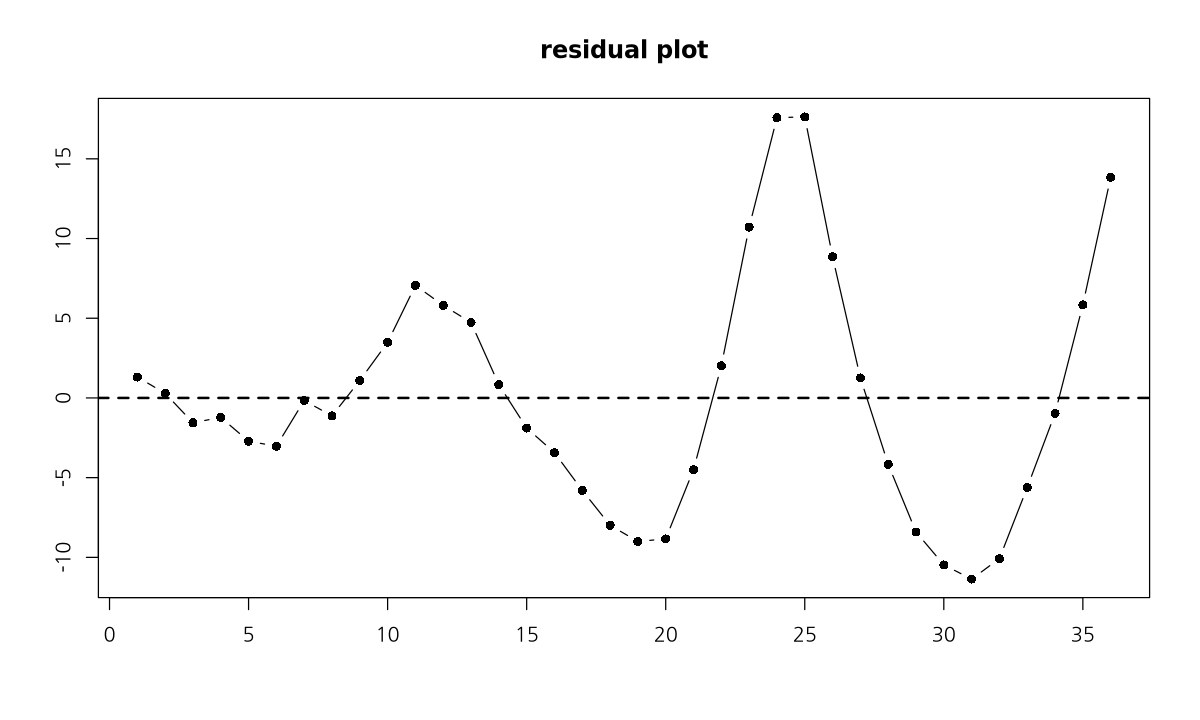

In [88]:
plot(tmp_data$t, resid(m2), pch = 16, main = 'residual plot', xlab = "", ylab = "", type = 'b')
abline(h = 0, lty = 2, lwd = 2)

> 참 모호하게 생긴 모형. 일단 회귀분석 기본가정에 부적합할듯

`-` 독립성 검정

In [93]:
dwtest(m2, alternative = 'two.sided')


	Durbin-Watson test

data:  m2
DW = 0.31083, p-value = 1.744e-13
alternative hypothesis: true autocorrelation is not 0


> 양의 자기상관 있음

In [103]:
## auto correlation
e = resid(m2)
cor(e[-1], e[-length(e)])

2*(1-cor(e[-1], e[-length(e)])) ## d값인 0.31083과 비슷하다는 것을 알 수 있음 ㅇㅇ

[1] 0.8385957

[1] 0.3228085

`-` 정규성 검정

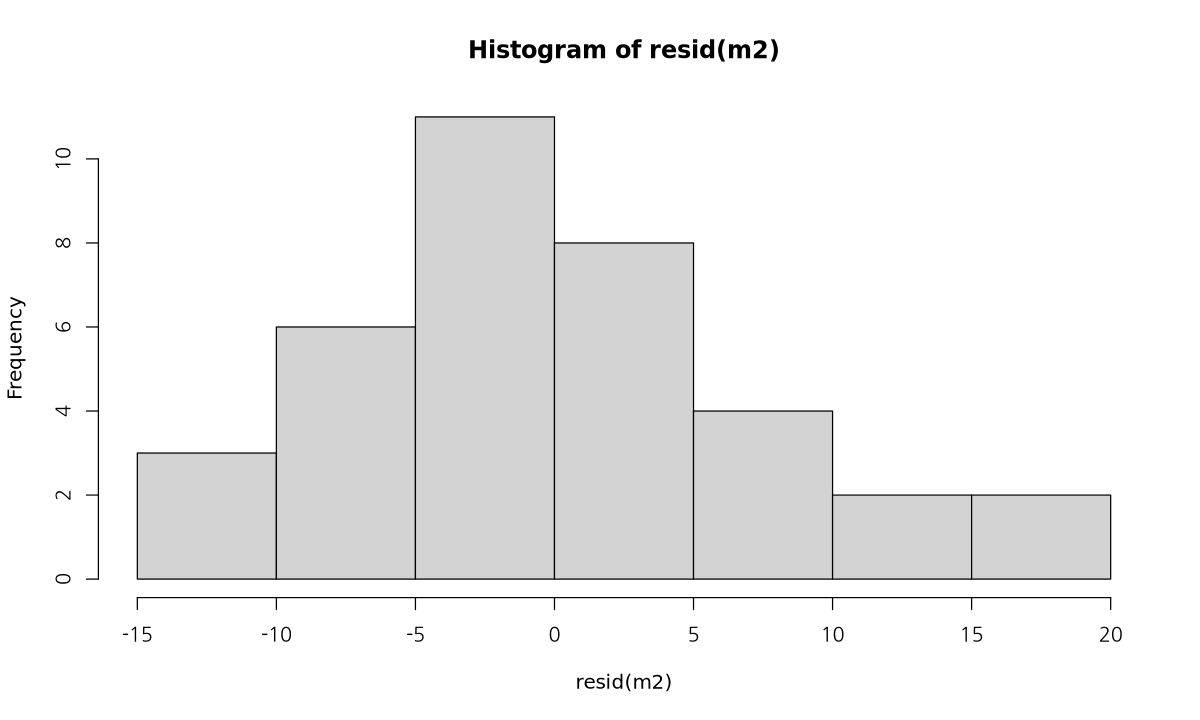

In [89]:
hist(resid(m2))

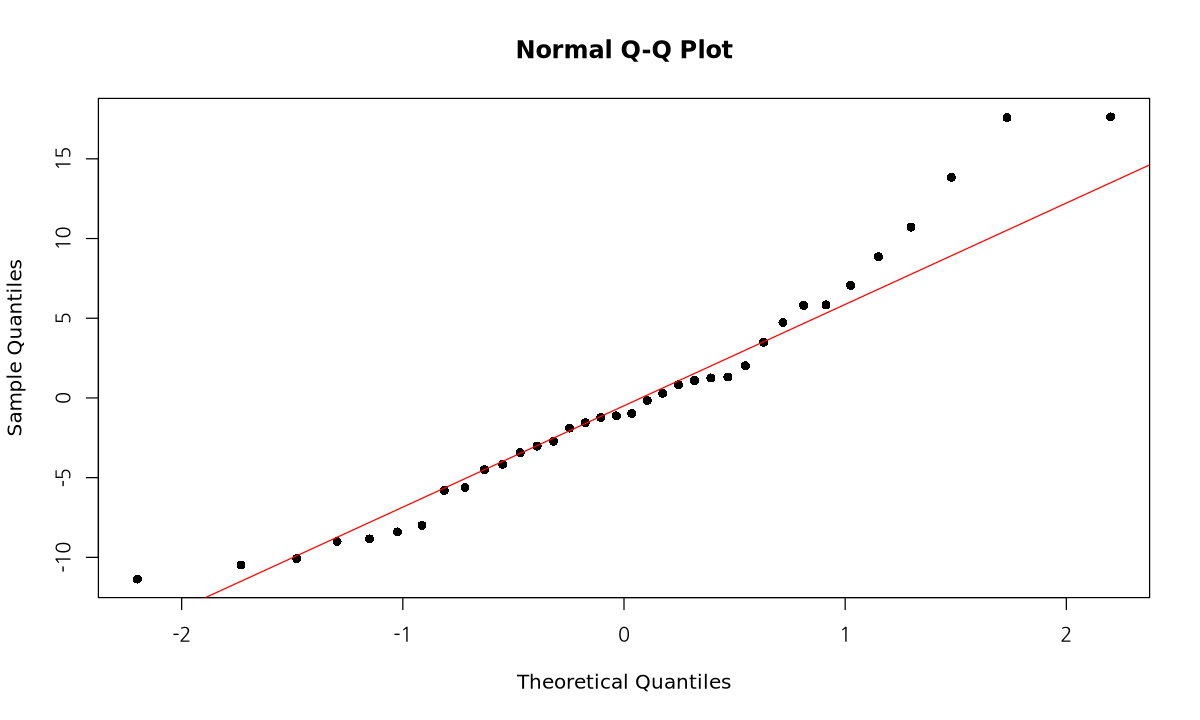

In [92]:
qqnorm(resid(m2), pch = 16)
qqline(resid(m2), col = 'red')

In [94]:
shapiro.test(resid(m2))


	Shapiro-Wilk normality test

data:  resid(m2)
W = 0.94947, p-value = 0.1007


> 좀 껄끄럽긴 하지만, 정규분포가 아니라고 할 순 없겠다.

`-` 등분산성 검정

In [95]:
bptest(m2)


	studentized Breusch-Pagan test

data:  m2
BP = 8.2455, df = 2, p-value = 0.0162


> 딱봐도 데이터가 시간의 흐름에 따라 잔차의 분산이 커지고 있긴 함. (로그변환해도 별로 좋아지진 않더라구요)

### C. 이분산성 해소를 위한 로그 변환...

모형 : $ln(Z_t) = \beta_0 + \beta_1 t + \beta_2 t^2 + \epsilon_t, ~ t = 1, \cdots, n$

In [104]:
m3 = lm(log(pop)~t+I(t^2), data = tmp_data)
summary(m3)


Call:
lm(formula = log(pop) ~ t + I(t^2), data = tmp_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.009306 -0.003520 -0.000374  0.003284  0.010159 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.807e+00  2.360e-03 3307.25   <2e-16 ***
t            2.740e-02  2.942e-04   93.14   <2e-16 ***
I(t^2)      -3.004e-04  7.712e-06  -38.95   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.004461 on 33 degrees of freedom
Multiple R-squared:  0.9994,	Adjusted R-squared:  0.9993 
F-statistic: 2.664e+04 on 2 and 33 DF,  p-value: < 2.2e-16


In [106]:
bptest(m3)


	studentized Breusch-Pagan test

data:  m3
BP = 8.8866, df = 2, p-value = 0.01176


## 4. 계절 성분

* $\sin(x), \cos(x)$ : 주기가 $2\pi$ 인 주기함수

In [107]:
x = seq(0, 48, 0.01)

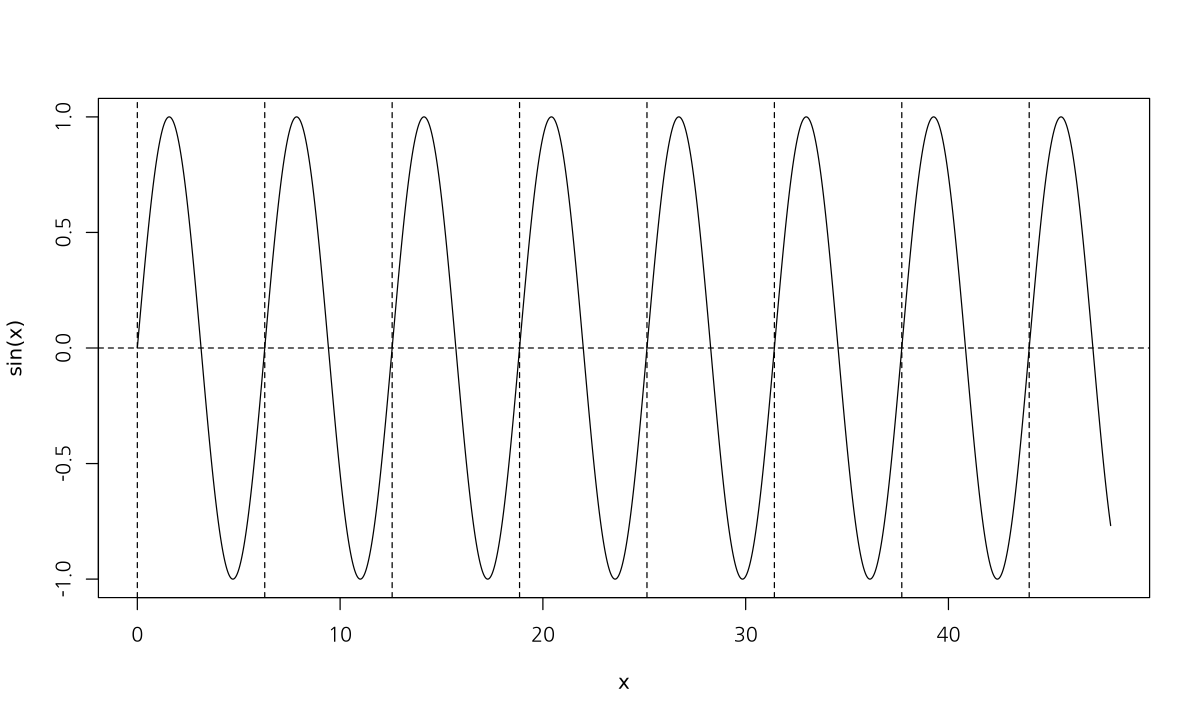

In [112]:
plot(x, sin(x), type = 'l')
abline(h = 0, lty = 2)
abline(v = seq(0, 48, by = 2*pi), lty = 2)

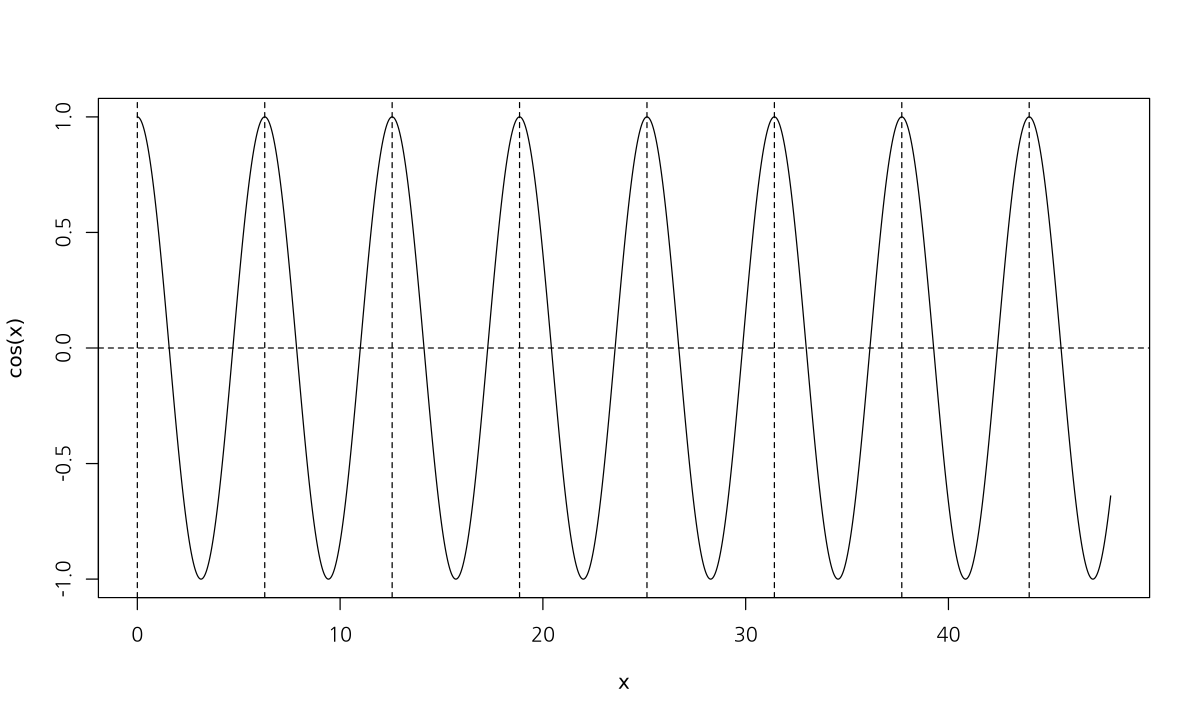

In [110]:
plot(x, cos(x), type = 'l')
abline(h = 0, lty = 2)
abline(v = seq(0, 48, by = 2*pi), lty = 2)

`-` 삼각함수의 주기 변동

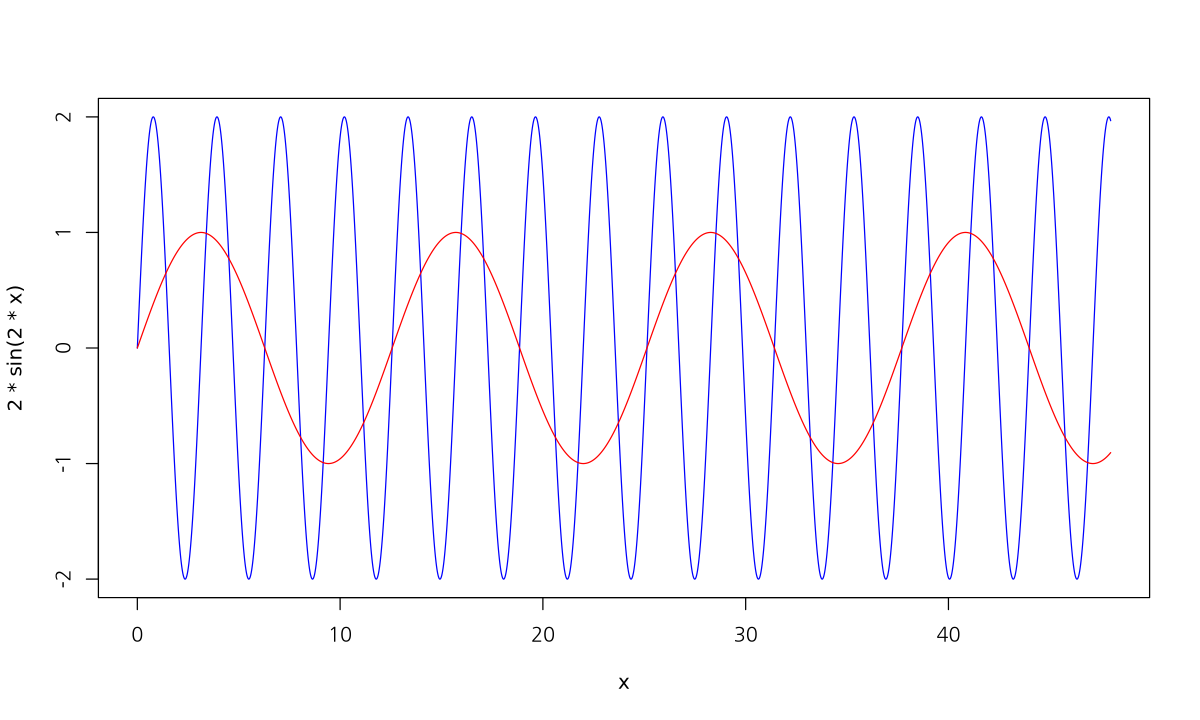

In [118]:
plot(x, 2*sin(2*x),type = 'l', col = 'blue')
lines(x, sin(0.5*x), type = 'l', col = 'red')

> 진폭과 주기를 변동시킬 수 있음.

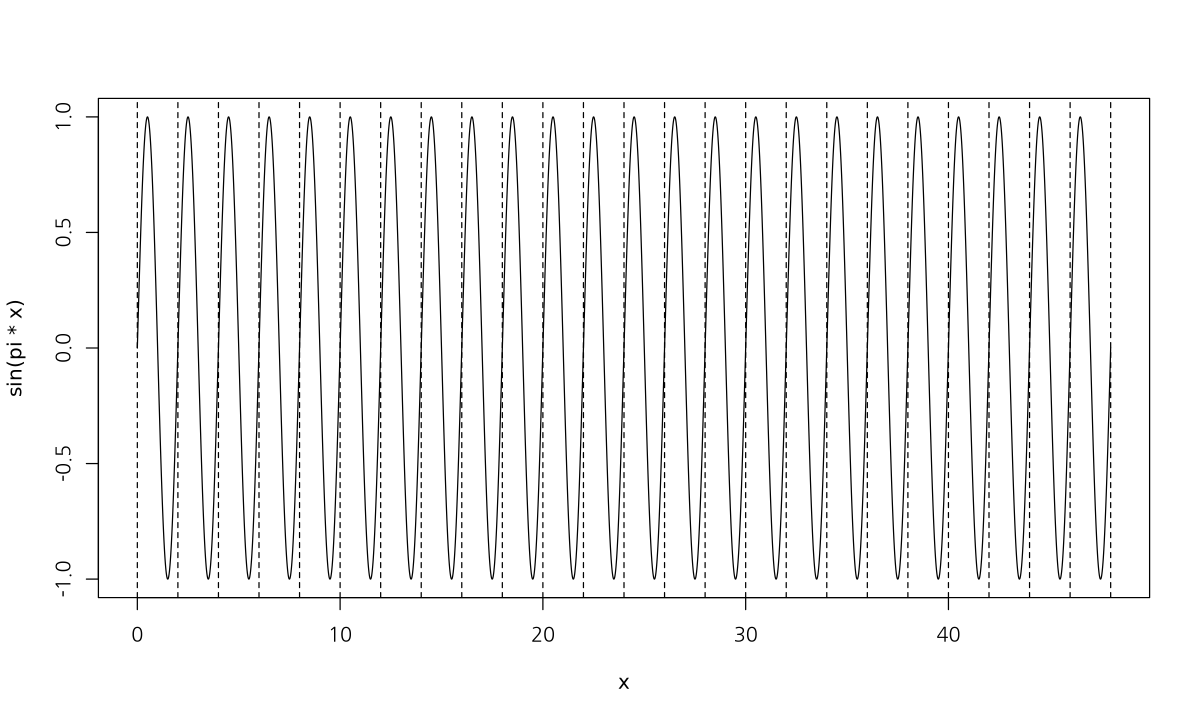

In [126]:
plot(x, sin(pi*x), type = 'l') ## 주기를 정수로 바꿈
abline(v = seq(0, 48, by = 2), lty = 2)

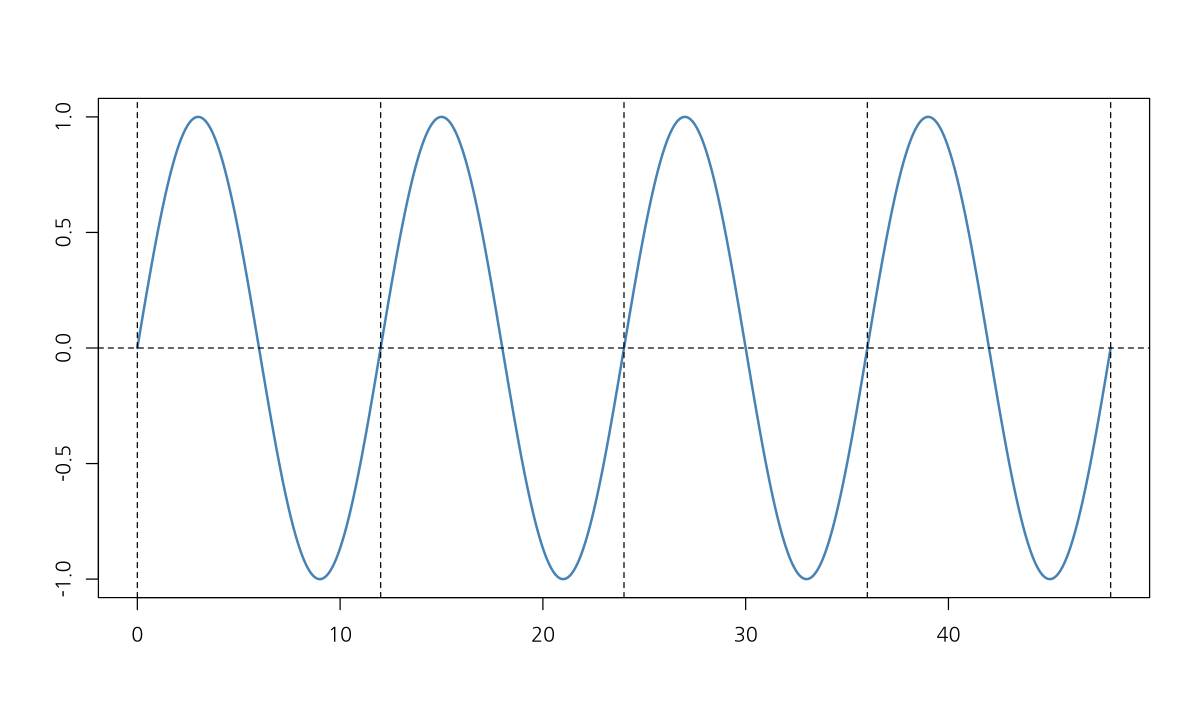

In [128]:
# 주기 = 12
s = 12
plot(x, sin(2*pi*x/s), type = 'l', col='steelblue', lwd = 2, xlab = "", ylab="")
abline(h = 0, lty = 2)
abline(v = seq(0, 48, by = s), lty = 2)

$\sin(x)$ 주기 : $2\pi$

$\sin(2x)$ 주기 : $2\pi/2 = \pi$

$\sin(3x)$ 주기 : $2\pi/3 = \frac23 \pi$

$\sin(\pi x)$ 주기 : $2\pi/\pi = 2$

> 수를 곱할수록 에너지가 늘어나서 파장이 짧아짐(주기 감소), 수로 나눌수록 에너지가 줄어들어 파장이 길어짐(주기 증가)

$$\underset{i = 1}{\overset{m}{\sum}} \sin(\frac{2\pi i}{s} t + \phi_t)$$

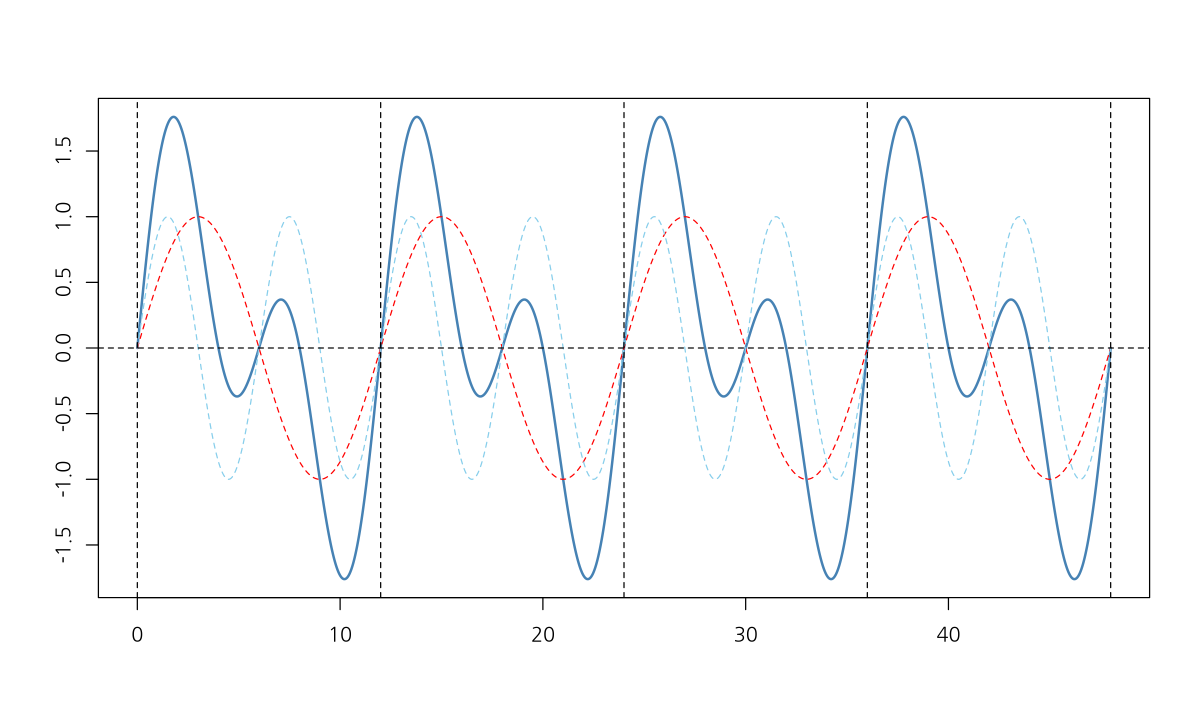

In [137]:
s = 12
plot(x, sin(2*pi*x/s) + sin(2*pi*x/6), type = 'l', col='steelblue', lwd = 2, xlab = "", ylab="")
lines(x, sin(2*pi*x/s), lty = 2, col = "red")
lines(x, sin(2*pi*x/6), lty = 2, col = "skyblue")
abline(h = 0, lty = 2)
abline(v = seq(0, 48, by = s), lty = 2)

> 공통 주기의 다양한 함수들을 더하고, 개별 함수들 간 진폭을 조절하면서 다양한 형태의 그래프들을 만들어낼 수 있다.
>
> $\sin$ 함수 내에 상수를 더하거나, 외부에 $\cos$ 함수를 더함으로써 그래프를 쉬프팅할 수도 있다.

`-` 주기 + 추세

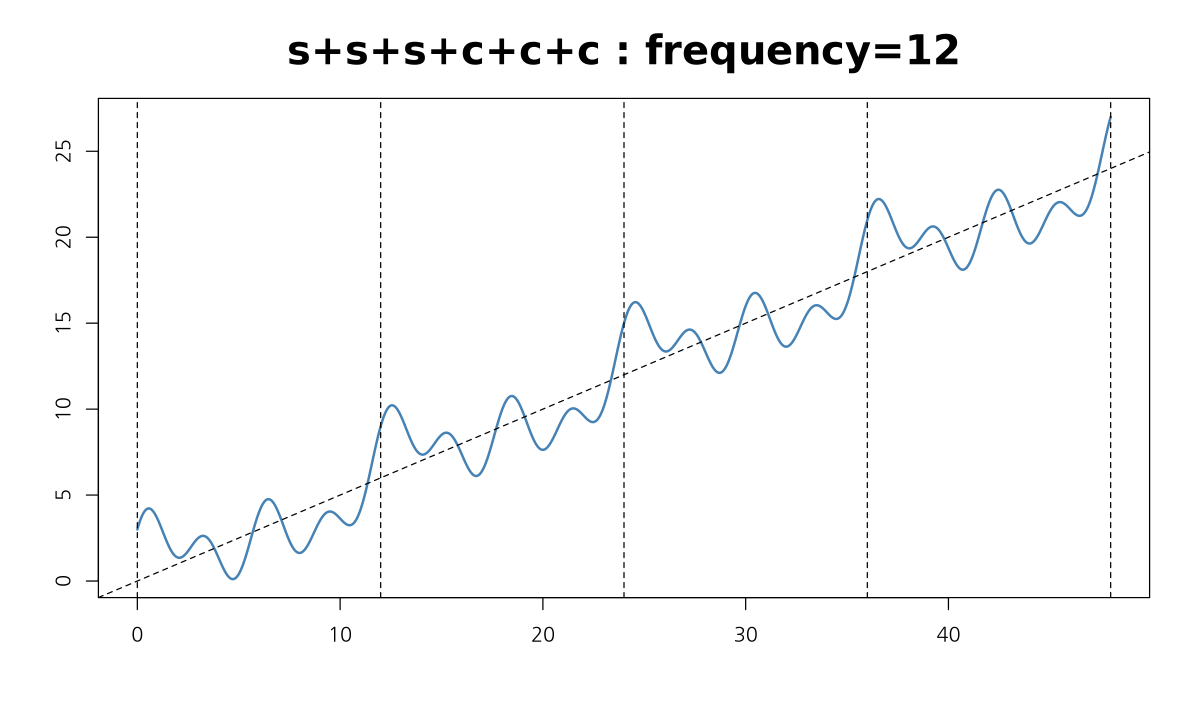

In [140]:
y2 <- x*0.5 + sin(2*pi*x/12)+sin(2*pi*x/6)+sin(2*pi*x/3)+ cos(2*pi*x/12)+cos(2*pi*x/6)+cos(2*pi*x/3)
plot(x,y2, type='l', col='steelblue', lwd=2, 
     xlab="", ylab="", main="s+s+s+c+c+c : frequency=12", cex.main=2)
abline(a = 0, b = 0.5, lty=2)
abline(v= seq(0, 48, by=12), lty=2)

## 5. 백화점 매출액 데이터 기반 분석

In [141]:
z = scan("depart.txt")
head(z)

[1] 423 458 607 564 536 536

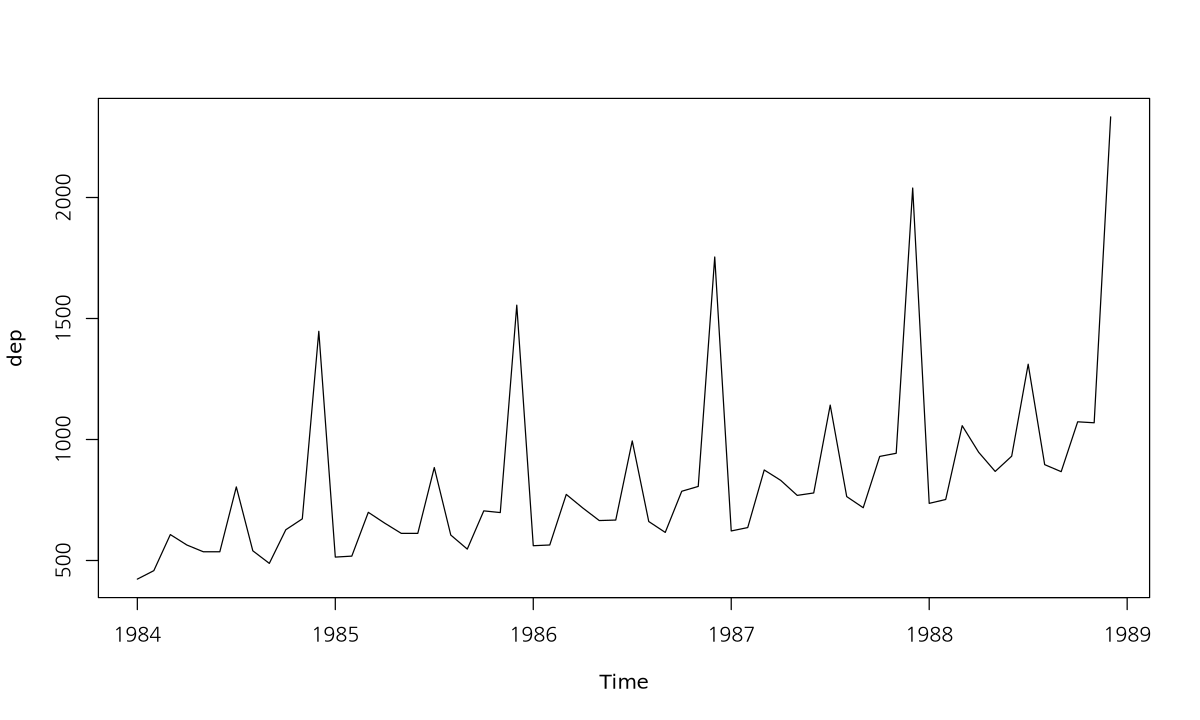

In [142]:
dep = ts(z, frequency = 12, start=c(1984, 1))
plot(dep)

> 계절성분과 추세가 모두 존재하는 데이터

### **A. 지시함수 이용**

In [146]:
lndep = log(z)
cycle(dep)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1984,1,2,3,4,5,6,7,8,9,10,11,12
1985,1,2,3,4,5,6,7,8,9,10,11,12
1986,1,2,3,4,5,6,7,8,9,10,11,12
1987,1,2,3,4,5,6,7,8,9,10,11,12
1988,1,2,3,4,5,6,7,8,9,10,11,12


In [158]:
tmp_data = data.frame(
    dep = z,
    lndep = log(z),
    day = seq(ymd("1984-01-01"), by = "1 month", length.out = length(z)),
    s = as.factor(cycle(dep)), ## seasonal : 범주형
    t = 1:length(z) ## trend : 등간격
    )
head(tmp_data)

,dep,lndep,day,s,t
,<dbl>,<dbl>,<date>,<fct>,<int>
1,423,6.047372,1984-01-01,1,1
2,458,6.126869,1984-02-01,2,2
3,607,6.408529,1984-03-01,3,3
4,564,6.335054,1984-04-01,4,4
5,536,6.284134,1984-05-01,5,5
6,536,6.284134,1984-06-01,6,6


In [159]:
reg = lm(lndep~t+s, tmp_data) ## 제약조건을 명시해야 함, default는 첫 번째 seasonal 변수를 0으로 설정함(dummy variable)
summary(reg)


Call:
lm(formula = lndep ~ t + s, data = tmp_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.038679 -0.018689 -0.001468  0.015185  0.057288 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.0641904  0.0122952 493.215  < 2e-16 ***
t           0.0106603  0.0001925  55.388  < 2e-16 ***
s2          0.0166091  0.0160024   1.038   0.3046    
s3          0.3169279  0.0160059  19.801  < 2e-16 ***
s4          0.2311551  0.0160117  14.437  < 2e-16 ***
s5          0.1490488  0.0160198   9.304 3.12e-12 ***
s6          0.1555867  0.0160302   9.706 8.32e-13 ***
s7          0.5243161  0.0160429  32.682  < 2e-16 ***
s8          0.1200927  0.0160579   7.479 1.54e-09 ***
s9          0.0359244  0.0160752   2.235   0.0302 *  
s10         0.2692601  0.0160948  16.730  < 2e-16 ***
s11         0.2775212  0.0161166  17.220  < 2e-16 ***
s12         1.0462912  0.0161407  64.823  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ 

> 유의확률은 s1(1월)과 차이가 있는지에 대한 것

`-` 세 가지 제약조건 반영

In [160]:
reg = lm(lndep~0+t+s, tmp_data) ## 절편이 0
summary(reg)


Call:
lm(formula = lndep ~ 0 + t + s, data = tmp_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.038679 -0.018689 -0.001468  0.015185  0.057288 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)    
t   0.0106603  0.0001925   55.39   <2e-16 ***
s1  6.0641904  0.0122952  493.21   <2e-16 ***
s2  6.0807995  0.0123718  491.50   <2e-16 ***
s3  6.3811183  0.0124509  512.50   <2e-16 ***
s4  6.2953455  0.0125325  502.32   <2e-16 ***
s5  6.2132392  0.0126164  492.47   <2e-16 ***
s6  6.2197771  0.0127027  489.64   <2e-16 ***
s7  6.5885065  0.0127914  515.08   <2e-16 ***
s8  6.1842831  0.0128823  480.06   <2e-16 ***
s9  6.1001148  0.0129754  470.13   <2e-16 ***
s10 6.3334505  0.0130707  484.56   <2e-16 ***
s11 6.3417116  0.0131681  481.60   <2e-16 ***
s12 7.1104816  0.0132676  535.93   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0253 on 47 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared

> 유의확률은 계절 별 기본값이 0인지에 대한 것

In [161]:
reg = lm(lndep~t+s, tmp_data, contrasts = list(s = 'contr.sum')) ## 계절성분 합계가 0
summary(reg)
## s12는 -(s1+...+s11)


Call:
lm(formula = lndep ~ t + s, data = tmp_data, contrasts = list(s = "contr.sum"))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.038679 -0.018689 -0.001468  0.015185  0.057288 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.3260849  0.0067177 941.703  < 2e-16 ***
t            0.0106603  0.0001925  55.388  < 2e-16 ***
s1          -0.2618944  0.0108845 -24.061  < 2e-16 ***
s2          -0.2452853  0.0108675 -22.571  < 2e-16 ***
s3           0.0550335  0.0108538   5.070 6.63e-06 ***
s4          -0.0307393  0.0108436  -2.835  0.00674 ** 
s5          -0.1128456  0.0108368 -10.413 8.53e-14 ***
s6          -0.1063078  0.0108334  -9.813 5.87e-13 ***
s7           0.2624217  0.0108334  24.223  < 2e-16 ***
s8          -0.1418018  0.0108368 -13.085  < 2e-16 ***
s9          -0.2259700  0.0108436 -20.839  < 2e-16 ***
s10          0.0073656  0.0108538   0.679  0.50071    
s11          0.0156268  0.0108675   1.438  0.15708    
---
Signif. co

> 유의확률은 절편값과 차이가 있는지에 대한 것

**하지만 뭐를 써도 fitted value는 같기 때문에 상관은 없다!**

`-` 시각화

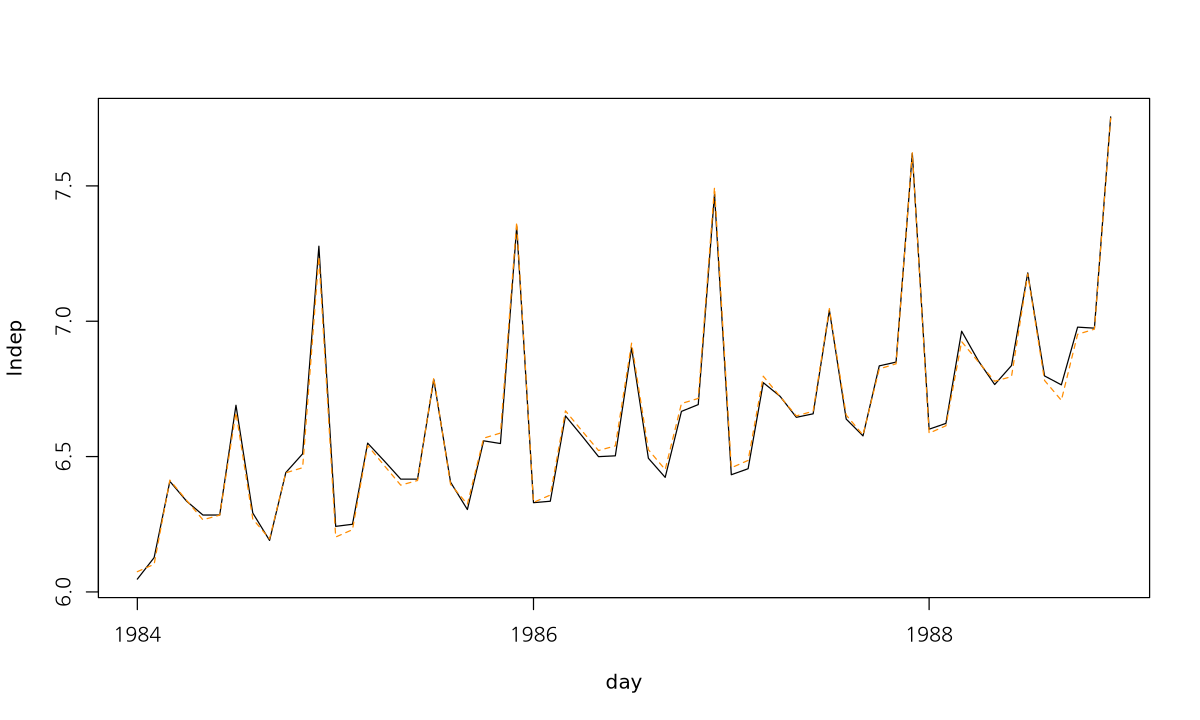

In [163]:
plot(lndep~day, tmp_data, type = 'l')
lines(tmp_data$day, fitted(reg), col = 'darkorange', lty = 2)

`-` 잔차분석

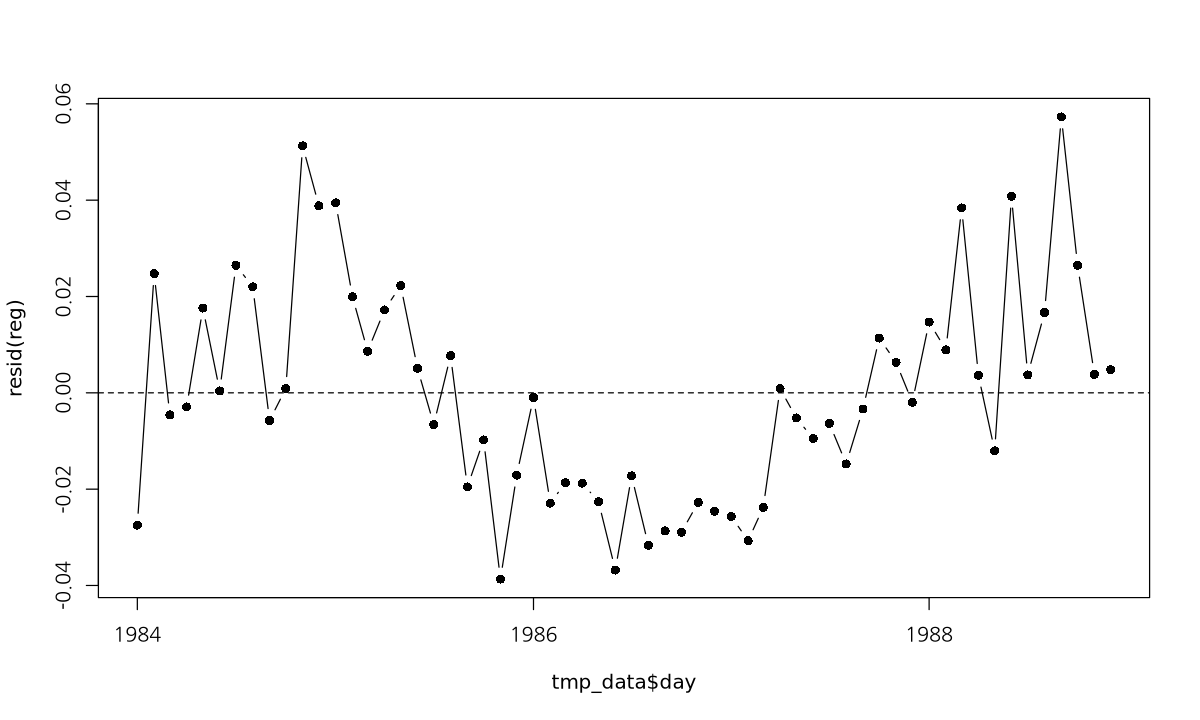

In [168]:
plot(tmp_data$day, resid(reg), type = 'b', pch = 16)
abline(h = 0, lty = 2)

In [164]:
dwtest(reg)


	Durbin-Watson test

data:  reg
DW = 0.82642, p-value = 2.39e-06
alternative hypothesis: true autocorrelation is greater than 0


> 양의 자기상관 있음

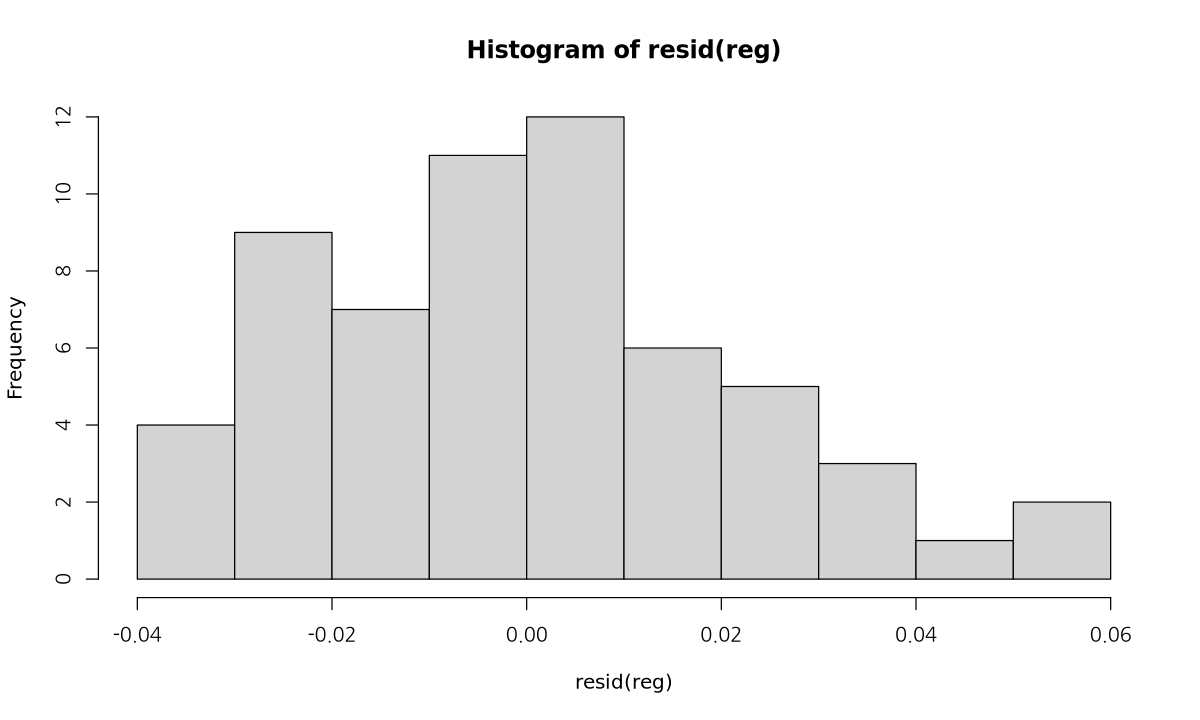

In [169]:
hist(resid(reg))

In [170]:
shapiro.test(resid(reg))


	Shapiro-Wilk normality test

data:  resid(reg)
W = 0.97114, p-value = 0.1659


In [171]:
bptest(reg)


	studentized Breusch-Pagan test

data:  reg
BP = 8.1109, df = 12, p-value = 0.7764


> 정규성, 등분산성은 위배 안함

`-` **잔차와 예측오차는 다름**

> 과거 데이터와 미래 데이터의 차이

* 적합값에 대한 MSE 구하기 : $MSE = \frac1n \sum^n_{t=1}(Z_t - \hat Z_t)^2$

비교할 때는 $\exp$로 다시 원래 데이터 사이즈에서 비교해야 한다.

In [178]:
length(tmp_data[,1])

[1] 60

[1] 353.6691

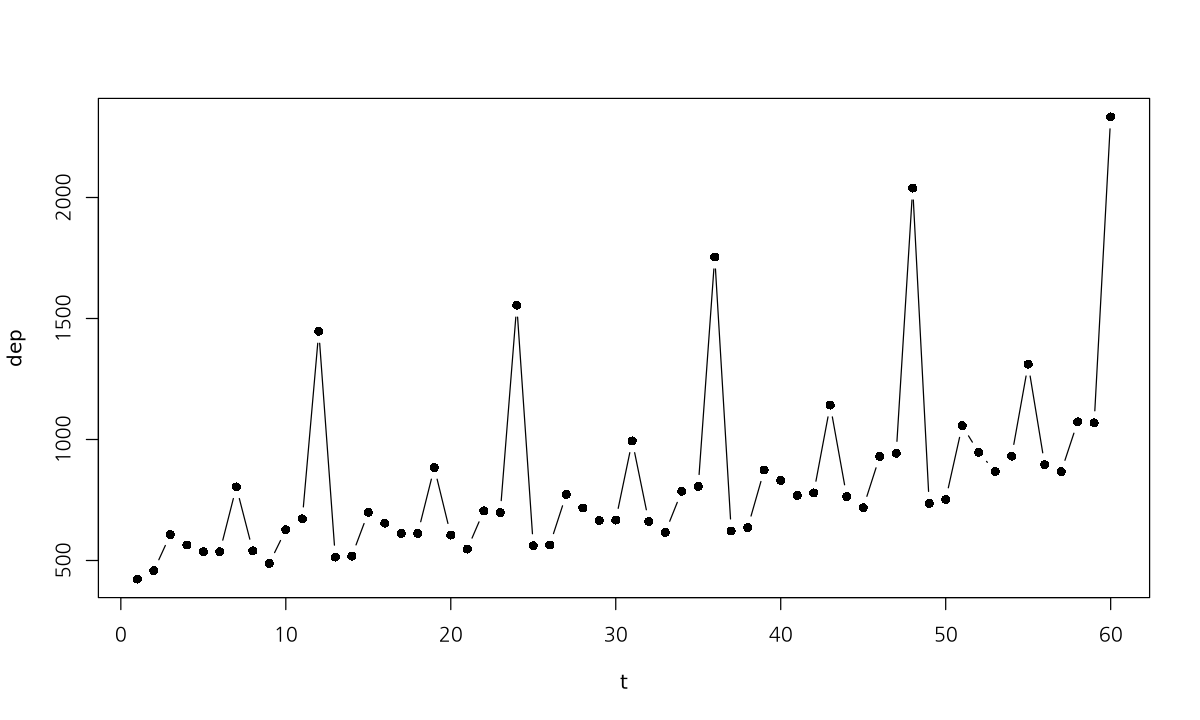

In [184]:
plot(dep~t, tmp_data, type = 'b', pch = 16)
mse1 = sum((tmp_data$dep - exp(fitted(reg)))^2)/60 ## 60으로 나누는 거 맞나요...? 자유도가...
mse1

### B. 삼각함수 사용

In [187]:
tmp_data2 = data.frame(
    lndep = tmp_data$lndep,
    trend = tmp_data$t)

In [188]:
head(tmp_data2)

,lndep,trend
,<dbl>,<int>
1,6.047372,1
2,6.126869,2
3,6.408529,3
4,6.335054,4
5,6.284134,5
6,6.284134,6


In [191]:
dt1 = Reduce(cbind.data.frame, lapply(as.list(1:5), function(i) sin(2*pi*i/12*tmp_data2$trend)))
head(dt1)

,init,x[[i]],x[[i]],x[[i]],x[[i]]
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.000000e-01,8.660254e-01,1.000000e+00,8.660254e-01,5.000000e-01
2,8.660254e-01,8.660254e-01,1.224647e-16,-8.660254e-01,-8.660254e-01
3,1.000000e+00,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000e+00
4,8.660254e-01,-8.660254e-01,-2.449294e-16,8.660254e-01,-8.660254e-01
5,5.000000e-01,-8.660254e-01,1.000000e+00,-8.660254e-01,5.000000e-01
6,1.224647e-16,-2.449294e-16,3.673940e-16,-4.898587e-16,6.123234e-16


In [197]:
names(dt1) = c('sin12', 'sin6', 'sin4', 'sin3', 'sin2.4')
head(dt1)

,sin12,sin6,sin4,sin3,sin2.4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.000000e-01,8.660254e-01,1.000000e+00,8.660254e-01,5.000000e-01
2,8.660254e-01,8.660254e-01,1.224647e-16,-8.660254e-01,-8.660254e-01
3,1.000000e+00,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000e+00
4,8.660254e-01,-8.660254e-01,-2.449294e-16,8.660254e-01,-8.660254e-01
5,5.000000e-01,-8.660254e-01,1.000000e+00,-8.660254e-01,5.000000e-01
6,1.224647e-16,-2.449294e-16,3.673940e-16,-4.898587e-16,6.123234e-16


In [198]:
dt2 = Reduce(cbind.data.frame, lapply(as.list(1:5), function(i) cos(2*pi*i/12*tmp_data2$trend)))
names(dt2) = paste("cos", c(12, 6, 4, 3, 2.4))
head(dt2)

,cos 12,cos 6,cos 4,cos 3,cos 2.4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8.660254e-01,0.5,6.123234e-17,-0.5,-8.660254e-01
2,5.000000e-01,-0.5,-1.000000e+00,-0.5,5.000000e-01
3,6.123234e-17,-1.0,-1.836970e-16,1.0,3.061617e-16
4,-5.000000e-01,-0.5,1.000000e+00,-0.5,-5.000000e-01
5,-8.660254e-01,0.5,3.061617e-16,-0.5,8.660254e-01
6,-1.000000e+00,1.0,-1.000000e+00,1.0,-1.000000e+00


`-` 삼각함수를 주가하여 데이터프레임 재생성

In [199]:
tmp_data3 = cbind.data.frame(tmp_data2, dt1, dt2)
head(tmp_data3)

,lndep,trend,sin12,sin6,sin4,sin3,sin2.4,cos 12,cos 6,cos 4,cos 3,cos 2.4
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6.047372,1,5.000000e-01,8.660254e-01,1.000000e+00,8.660254e-01,5.000000e-01,8.660254e-01,0.5,6.123234e-17,-0.5,-8.660254e-01
2,6.126869,2,8.660254e-01,8.660254e-01,1.224647e-16,-8.660254e-01,-8.660254e-01,5.000000e-01,-0.5,-1.000000e+00,-0.5,5.000000e-01
3,6.408529,3,1.000000e+00,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000e+00,6.123234e-17,-1.0,-1.836970e-16,1.0,3.061617e-16
4,6.335054,4,8.660254e-01,-8.660254e-01,-2.449294e-16,8.660254e-01,-8.660254e-01,-5.000000e-01,-0.5,1.000000e+00,-0.5,-5.000000e-01
5,6.284134,5,5.000000e-01,-8.660254e-01,1.000000e+00,-8.660254e-01,5.000000e-01,-8.660254e-01,0.5,3.061617e-16,-0.5,8.660254e-01
6,6.284134,6,1.224647e-16,-2.449294e-16,3.673940e-16,-4.898587e-16,6.123234e-16,-1.000000e+00,1.0,-1.000000e+00,1.0,-1.000000e+00


* 모형 적합 : $Z_t = \beta_0 + \beta_1 t + \sum^5_{t=1}\{\beta_{1, i} \sin(\frac{2\pi i}{12} t) + \beta_{2, i} \cos(\frac{2\pi i}{12}t)\}$ -> sin 다섯개, cos 다섯개

In [200]:
reg_sin = lm(lndep~., data = tmp_data3)
summary(reg_sin)


Call:
lm(formula = lndep ~ ., data = tmp_data3)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.08232 -0.04855  0.00972  0.04645  0.08527 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.3237250  0.0148062 427.100  < 2e-16 ***
trend        0.0107376  0.0004242  25.315  < 2e-16 ***
sin12       -0.0277129  0.0103066  -2.689 0.009829 ** 
sin6        -0.0382551  0.0102107  -3.747 0.000481 ***
sin4        -0.1555546  0.0101931 -15.261  < 2e-16 ***
sin3         0.0666506  0.0101872   6.543 3.70e-08 ***
sin2.4       0.0128922  0.0101849   1.266 0.211691    
`cos 12`     0.0857900  0.0101931   8.416 5.21e-11 ***
`cos 6`      0.1675743  0.0101931  16.440  < 2e-16 ***
`cos 4`      0.1592698  0.0101931  15.625  < 2e-16 ***
`cos 3`      0.1267107  0.0101931  12.431  < 2e-16 ***
`cos 2.4`    0.2000603  0.0101931  19.627  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05578 on 48 degrees of

integer(0)

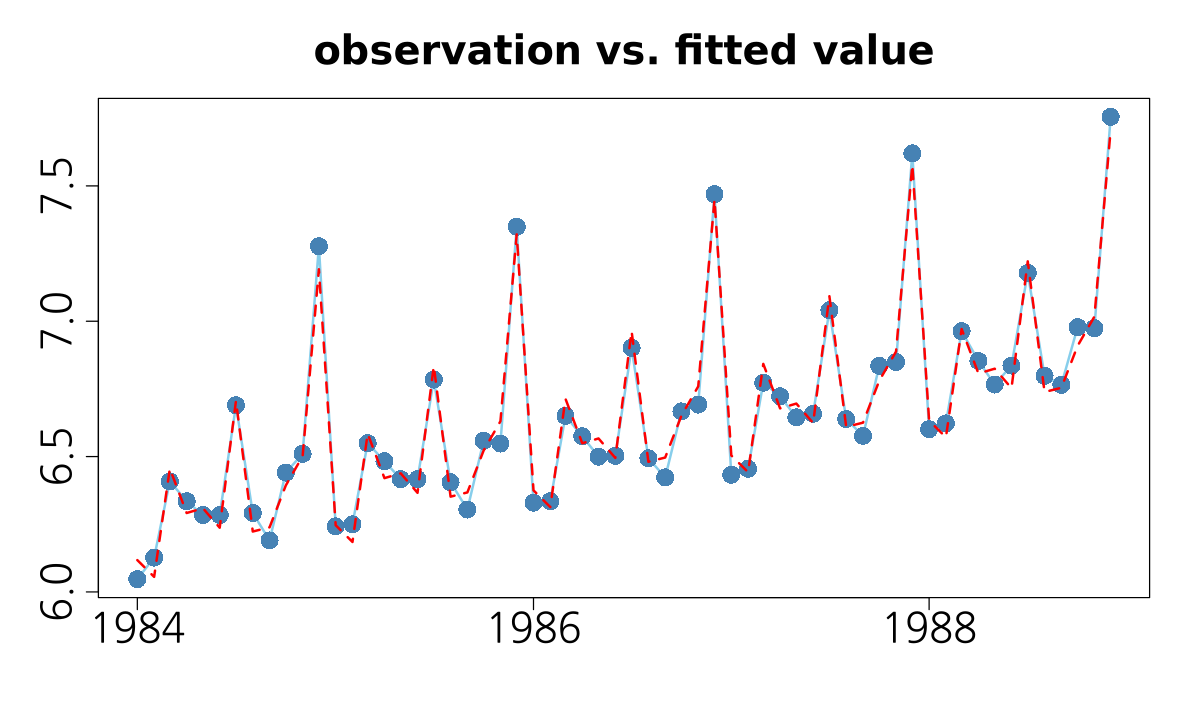

In [203]:
plot(lndep~tmp_data$day, tmp_data3,
 main = 'observation vs. fitted value',
 xlab="", ylab="",
 type='l',
 col='skyblue',
 lwd=2, cex.axis=2, cex.main=2) +
 points(lndep~day, tmp_data, col="steelblue", cex=2, pch=16) +
 lines(tmp_data$day, fitted(reg_sin), col='red', lty=2, lwd=2)

`-` 잔차 분석

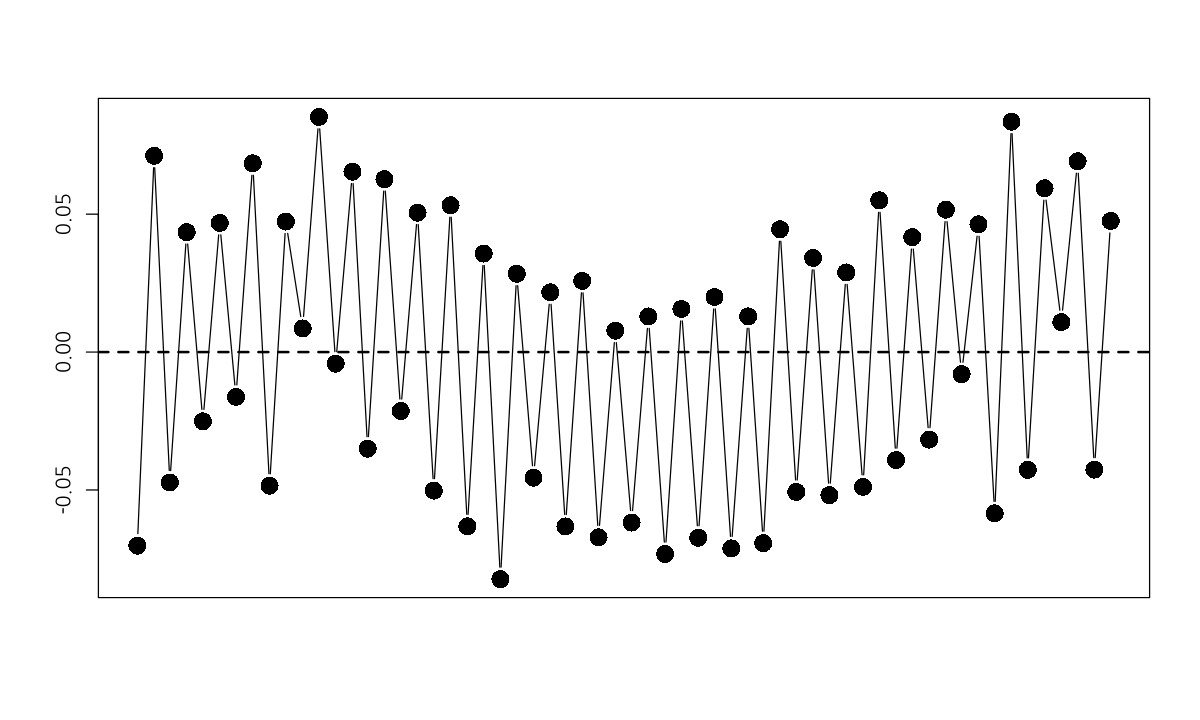

In [205]:
plot(tmp_data$day, resid(reg_sin), pch = 16, cex = 2, xaxt = 'n', type = 'b', xlab = "", ylab = "")
abline(h = 0, lty = 2, lwd = 2)

In [206]:
dwtest(reg_sin)


	Durbin-Watson test

data:  reg_sin
DW = 3.2703, p-value = 1
alternative hypothesis: true autocorrelation is greater than 0


In [207]:
shapiro.test(resid(reg_sin))


	Shapiro-Wilk normality test

data:  resid(reg_sin)
W = 0.92295, p-value = 0.00101


In [208]:
bptest(reg_sin)


	studentized Breusch-Pagan test

data:  reg_sin
BP = 0.99264, df = 11, p-value = 1


In [213]:
mse_reg_indicator = sum((z - exp(fitted(reg)))^2)/length(z)
mse_reg_indicator

[1] 353.6691

In [212]:
mse_reg_sin = sum((z - exp(fitted(reg_sin)))^2)/length(z)
mse_reg_sin

[1] 1928.976

Indicator를 사용한 모형이 mse 관점에서 더 좋다는 사실을 알 수 있음.

### C. Forecasting

In [220]:
tail(tmp_data)

,dep,lndep,day,s,t
,<dbl>,<dbl>,<date>,<fct>,<int>
55,1311,7.178545,1988-07-01,7,55
56,896,6.797940,1988-08-01,8,56
57,867,6.765039,1988-09-01,9,57
58,1073,6.978214,1988-10-01,10,58
59,1069,6.974479,1988-11-01,11,59
60,2333,7.754910,1988-12-01,12,60


> 60번째 관측치 이후부터 1년동안 예측하고자 한다면?

In [223]:
new_data = data.frame(
    t = 61:72,
    s = as.factor(1:12)
)
new_data

t,s
<int>,<fct>
61,1
62,2
63,3
64,4
65,5
66,6
67,7
68,8
69,9


In [225]:
predict(reg, newdata = new_data) ## 파라미터가 12개이지만, factor column으로 하나만 넣어도 충분하다.

1        2        3        4        5        6        7        8 
6.714467 6.741737 7.052716 6.977603 6.906157 6.923355 7.302745 6.909182 
       9       10       11       12 
6.835674 7.079670 7.098591 7.878021

In [226]:
## 실제 예측값
exp(predict(reg, newdata = new_data))

1         2         3         4         5         6         7         8 
 824.2445  847.0305 1155.9938 1072.3451  998.4032 1015.7223 1484.3690 1001.4276 
        9        10        11        12 
 930.4552 1187.5763 1210.2609 2638.6468

`-` confidence interval

In [232]:
exp(predict(reg, newdata = new_data, interval = "confidence")) ## 평균반응
exp(predict(reg, newdata = new_data, interval = "predict")) ## 개별 관측치

,fit,lwr,upr
1,824.2445,802.5357,846.5406
2,847.0305,824.7215,869.9429
3,1155.9938,1125.5475,1187.2638
4,1072.3451,1044.1018,1101.3523
5,998.4032,972.1074,1025.4103
6,1015.7223,988.9704,1043.1979
7,1484.3690,1445.2739,1524.5216
8,1001.4276,975.0522,1028.5165
9,930.4552,905.9490,955.6242
10,1187.5763,1156.2981,1219.7006


,fit,lwr,upr
1,824.2445,778.2095,873.0027
2,847.0305,799.7228,897.1365
3,1155.9938,1091.4303,1224.3767
4,1072.3451,1012.4534,1135.7797
5,998.4032,942.6412,1057.4637
6,1015.7223,958.9931,1075.8074
7,1484.3690,1401.4653,1572.1768
8,1001.4276,945.4967,1060.6671
9,930.4552,878.4882,985.4962
10,1187.5763,1121.2489,1257.8274


`-` 예측값 시각화

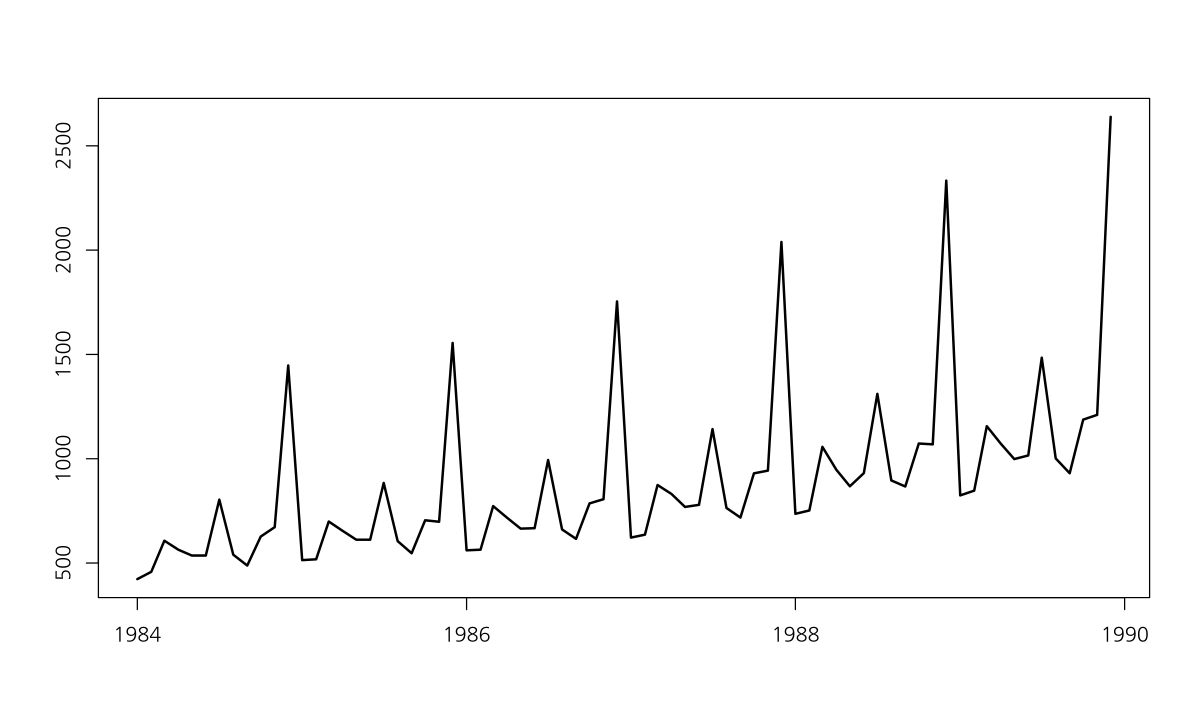

In [247]:
plot(c(tmp_data$day, seq(ymd('1989-01-01'), by = "month", length.out = 12)),
     c(exp(tmp_data$lndep), exp(predict(reg, new_data))),
    xlab = "", ylab = "", type = 'l', lwd = 2)

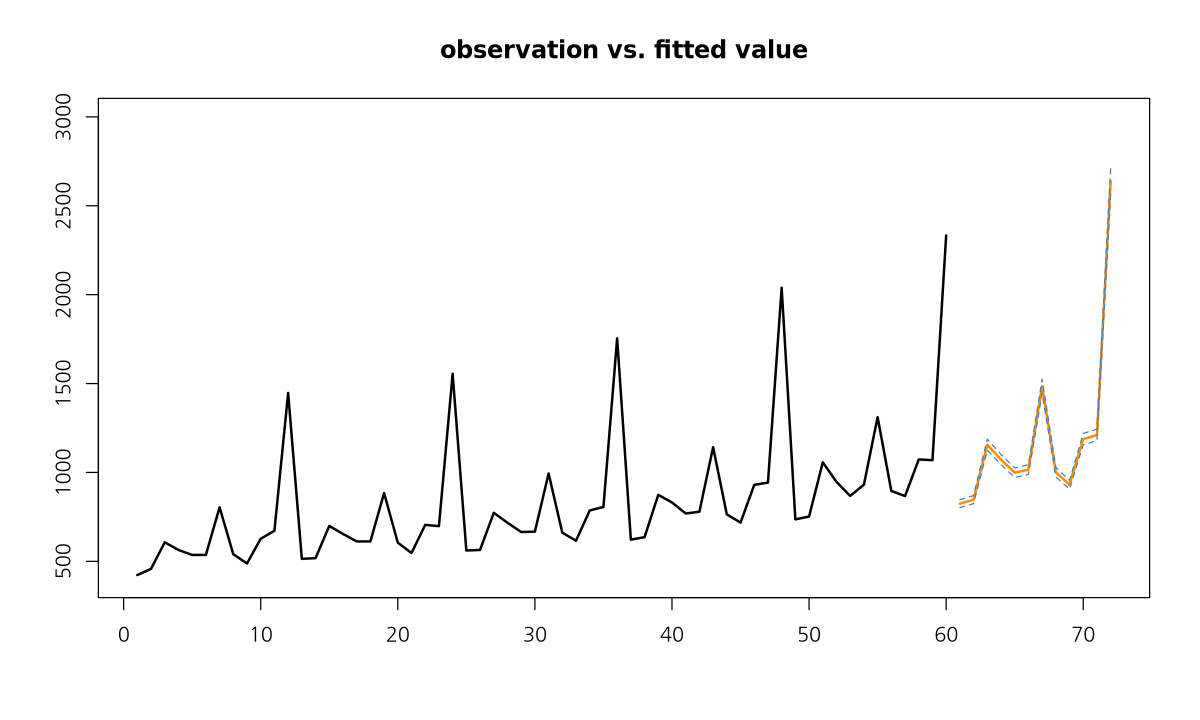

In [258]:
plot(z~tmp_data$t, tmp_data,
 main = 'observation vs. fitted value',
 xlab="", ylab="",
 xlim=c(1,72),
 ylim=c(400,3000),
 type='l',
 lwd=2)

predict_result = exp(predict(reg, newdata = new_data, interval = "confidence")) ## 평균반응

lines(61:72, predict_result[, 1], col='darkorange', lwd=2)
lines(61:72, predict_result[, 2], col='steelblue', lwd=1, lty=2)
lines(61:72, predict_result[, 3], col='steelblue', lwd=1, lty=2)